In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Reload a trained model

In [ ]:
### Load data
train = pd.read_hdf("train_dnn.h5")
val = pd.read_hdf("val_dnn.h5")
test = pd.read_hdf("test_dnn.h5")
test.reset_index(inplace=True)

### All clusters + track eta/phi/z0
train_vars = [var for var in test.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
train_vars += ['track_eta', 'track_phi', 'track_z0']

train_x = train[train_vars].values
train_y = train['log10_truth_particle_e'].values
val_x = val[train_vars].values
val_y = val['log10_truth_particle_e'].values
test_x = test[train_vars].values
test_y = test['log10_truth_particle_e'].values

### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
val_x = sc.transform(val_x)
test_x = sc.transform(test_x)

def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

model = regression_model()
model.load_weights("dnn_best_weights_50.h5")
test['nn_output'] = 10**model.predict(test_x) # re-exponentiate the energy

In [ ]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = test.truth_particle_e
y = (test.nn_output)/x

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');
np.savez('pub_note_results/response_median_dnn_50.npz', response_median=profileXMed, xcenter=xcenter)

In [ ]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
resolution = stats.binned_statistic(x, y, bins=xbin, statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6), dpi=200)
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');

np.savez('pub_note_results/iqr_dnn_50.npz', iqr=resolution, xcenter=xcenter)

In [ ]:
np.min(test.nn_output/test.truth_particle_e)

In [ ]:
test[(test.truth_particle_e > 100) & (test.truth_particle_e < 101) & 
   (test.nn_output/test.truth_particle_e < 0.2)][["nn_output", "truth_particle_e"]]

In [ ]:
plt.hist(test.nn_output/test.truth_particle_e, bins=np.linspace(0,2,100));

Now compare to Transformer event...

In [ ]:
transformer = np.load('pub_note_results/Attention_Prediction_TRK_MarielFile.npz') # as of July 24
df_transformer = pd.DataFrame(np.vstack([transformer['target'],transformer['prediction']]).T, columns=["targets_regress", "outputs_regress"])

In [ ]:
len(test) == len(df_transformer)

In [ ]:
test.keys()

In [ ]:
test.truth_particle_e

In [ ]:
df_transformer.targets_regress

In [ ]:
np.sum(test.truth_particle_e == df_transformer.targets_regress)/len(test) 
# okay, so these are definitely identical events!

In [ ]:
np.min(df_transformer.outputs_regress/df_transformer.targets_regress)

In [ ]:
plt.hist(df_transformer.outputs_regress/df_transformer.targets_regress, bins=np.linspace(0,2,100));

In [ ]:
test[(np.abs(test.truth_particle_e - 1000) < 5)  # close to 100 GeV
     & 
     (test.nn_output/test.truth_particle_e < 0.5)  # DNN does badly
    ][["nn_output", "truth_particle_e"]]

In [ ]:
test.iloc[970158].nn_output

In [ ]:
df_transformer.iloc[970158]

In [ ]:
indices = [73920, 379097, 585445, 966165, 278235, 970158]

In [ ]:
test.keys()

In [ ]:
test.iloc[indices].truth_particle_e

In [ ]:
test.iloc[indices][["truth_particle_e","track_pt", "track_eta", "track_phi", "track_z0"]]

In [ ]:
test.iloc[indices][["truth_particle_e","cluster_e_0", "cluster_e_1", "cluster_e_2", "cluster_e_3"]]

# Load data

### Premade

In [ ]:
df_train = pd.read_hdf("train_dnn.h5")
df_val = pd.read_hdf("val_dnn.h5")
df_test = pd.read_hdf("test_dnn.h5")

### or, remake from scratch:

In [2]:
files = glob.glob("../data/onetrack_multicluster_sanmay/pion_files/*.npy")
train = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:30])])
val = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[30:40])])
test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[40:50])])

# train = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:350])])
# val = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[350:400])])
# test = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[400:])])
print("Training dataframe has {:,} events.".format(train.shape[0]))
print("Validation dataframe has {:,} events.".format(val.shape[0]))
print("Testing dataframe has {:,} events.".format(test.shape[0]))

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Training dataframe has 308,717 events.
Validation dataframe has 102,715 events.
Testing dataframe has 102,803 events.


In [42]:
### SANMAY'S VARIABLES
cluster_var = ['cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT',
               'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 
               'cluster_CENTER_LAMBDA', 'cluster_ISOLATION'
              ]

track_var = ['trackPt',
             'trackP',
             'trackMass',
             'trackEta',
             'trackPhi',
             'trackNumberOfPixelHits',
             'trackNumberOfSCTHits',
             'trackNumberOfPixelDeadSensors',
             'trackNumberOfSCTDeadSensors',
             'trackNumberOfInnermostPixelLayerHits',
             'trackNumberOfNextToInnermostPixelLayerHits',
             'trackExpectInnermostPixelLayerHit',
             'trackExpectNextToInnermostPixelLayerHit',
             'trackNumberOfTRTHits',
             'trackNumberOfTRTOutliers',
             'trackChiSquared',
             'trackNumberDOF',
             'trackD0',
             'trackZ0'
            ]

In [78]:
df1 = pd.DataFrame(pd.DataFrame(train.cluster_EM_PROBABILITY.to_list(), columns=["cluster_em_prob_"+str(x) for x in np.arange(33)]))

In [79]:
df2 = pd.DataFrame(pd.DataFrame(train.cluster_CENTER_LAMBDA.to_list(), columns=["cluster_CENTER_LAMBDA_"+str(x) for x in np.arange(33)]))

In [84]:
pd.concat([df1, df2])

,cluster_em_prob_0,cluster_em_prob_1,cluster_em_prob_2,cluster_em_prob_3,cluster_em_prob_4,cluster_em_prob_5,cluster_em_prob_6,cluster_em_prob_7,cluster_em_prob_8,cluster_em_prob_9,...,cluster_CENTER_LAMBDA_23,cluster_CENTER_LAMBDA_24,cluster_CENTER_LAMBDA_25,cluster_CENTER_LAMBDA_26,cluster_CENTER_LAMBDA_27,cluster_CENTER_LAMBDA_28,cluster_CENTER_LAMBDA_29,cluster_CENTER_LAMBDA_30,cluster_CENTER_LAMBDA_31,cluster_CENTER_LAMBDA_32
0,0.001000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.208537,0.000131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002079,0.000447,0.006793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000479,0.000402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.002325,0.000953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
def process(df): 
    ### Start the dataframe of inputs 
    ncols = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())).shape[1]
    df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(ncols)]))
    
    ### Add Sanmay's cluster inputs
    dfs = []
    for var in cluster_var:
        dfs.append(pd.DataFrame(pd.DataFrame(df[var].to_list(), columns=[str(var)+str(x) for x in np.arange(ncols)])))
    df_cluster = pd.concat(dfs, axis=1)
    df2 = pd.concat([df2, df_cluster], axis=1)
    
    ### Add Sanmay's track inputs 
    for var in track_var:
        df2[var] = np.array(df[var].explode())
    
    ### Add track pT & truth particle E 
    track_pt = np.array(df.trackPt.explode())
    truth_particle_e = np.array(df.truthPartE.explode())
    track_eta = np.array(df.trackEta.explode())
    track_phi = np.array(df.trackPhi.explode())
    track_z0 = np.array(df.trackZ0.explode())

    df2["track_pt"] = track_pt
    df2["track_eta"] = track_eta
    df2["track_phi"] = track_phi
    df2["track_z0"] = track_z0
    df2["truth_particle_e"] = truth_particle_e

    ### Drop infs/NaNs 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)

    ### Cluster_E > 0.5
    df2 = df2[df2.cluster_e_0 > 0.5]

    ### Lose outliers in track pT 
    df2 = df2[df2.track_pt < 5000]

    ### Cast as float
    df2 = df2.astype('float32')

    ### Add the log of all energy variables
    for var in df2.keys():
        if var == "track_pt" or var == "truth_particle_e" or var.startswith("cluster_e_"):
            df2['log10_'+var] = np.log10(df2[var])
        else:
            continue

    ### Do this again? 
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)
    df2 = df2.fillna(0)
    return df2

In [94]:
df_train = process(train)
df_val = process(val)
df_test = process(test)

  0%|          | 0/321 [00:00<?, ?it/s]/clusterfs/ml4hep/mpettee/miniconda3/envs/nbdev/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 294/294 [00:00<00:00, 7463.85it/s]


In [124]:
df_train.to_hdf("train_dnn_sanmay.h5", "df")
df_val.to_hdf("val_dnn_sanmay.h5", "df")
df_test.to_hdf("test_dnn_sanmay.h5", "df")

In [97]:
np.array(df_train.keys())

array(['cluster_e_0', 'cluster_e_1', 'cluster_e_2', 'cluster_e_3',
       'cluster_e_4', 'cluster_e_5', 'cluster_e_6', 'cluster_e_7',
       'cluster_e_8', 'cluster_e_9', 'cluster_e_10', 'cluster_e_11',
       'cluster_e_12', 'cluster_e_13', 'cluster_e_14', 'cluster_e_15',
       'cluster_e_16', 'cluster_e_17', 'cluster_e_18', 'cluster_e_19',
       'cluster_e_20', 'cluster_e_21', 'cluster_e_22', 'cluster_e_23',
       'cluster_e_24', 'cluster_e_25', 'cluster_e_26', 'cluster_e_27',
       'cluster_e_28', 'cluster_e_29', 'cluster_e_30', 'cluster_e_31',
       'cluster_e_32', 'cluster_EM_PROBABILITY0',
       'cluster_EM_PROBABILITY1', 'cluster_EM_PROBABILITY2',
       'cluster_EM_PROBABILITY3', 'cluster_EM_PROBABILITY4',
       'cluster_EM_PROBABILITY5', 'cluster_EM_PROBABILITY6',
       'cluster_EM_PROBABILITY7', 'cluster_EM_PROBABILITY8',
       'cluster_EM_PROBABILITY9', 'cluster_EM_PROBABILITY10',
       'cluster_EM_PROBABILITY11', 'cluster_EM_PROBABILITY12',
       'cluster_EM_PROB

# Preprocess

In [218]:
### All clusters + track pt/eta/phi/z0
train_vars = [var for var in df_train.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
train_vars += ['track_eta', 'track_phi', 'track_z0']
# train_vars += [var for var in df_train.keys() if var.startswith('track')]
# train_vars += [var for var in df_train.keys() if var.startswith('cluster') and not var.startswith('cluster_e')]

for i in range(29, 33):
    train_vars.remove('log10_cluster_e_'+str(i))
    # for var in cluster_var:
    #     train_vars.remove(var+str(i))

print(train_vars)

### Augment df_test with any extra columns needed
df_test[[var for var in df_train.keys() if var not in df_test.keys()]] = 0 

train_x = df_train[train_vars].values
train_y = df_train['log10_truth_particle_e'].values
val_x = df_val[train_vars].values
val_y = df_val['log10_truth_particle_e'].values
test_x = df_test[train_vars].values
test_y = df_test['log10_truth_particle_e'].values

['log10_cluster_e_0', 'log10_cluster_e_1', 'log10_cluster_e_2', 'log10_cluster_e_3', 'log10_cluster_e_4', 'log10_cluster_e_5', 'log10_cluster_e_6', 'log10_cluster_e_7', 'log10_cluster_e_8', 'log10_cluster_e_9', 'log10_cluster_e_10', 'log10_cluster_e_11', 'log10_cluster_e_12', 'log10_cluster_e_13', 'log10_cluster_e_14', 'log10_cluster_e_15', 'log10_cluster_e_16', 'log10_cluster_e_17', 'log10_cluster_e_18', 'log10_cluster_e_19', 'log10_cluster_e_20', 'log10_cluster_e_21', 'log10_cluster_e_22', 'log10_cluster_e_23', 'log10_cluster_e_24', 'log10_cluster_e_25', 'log10_cluster_e_26', 'log10_cluster_e_27', 'log10_cluster_e_28', 'log10_track_pt', 'track_eta', 'track_phi', 'track_z0']


In [219]:
### Normalize the inputs 
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
val_x = sc.transform(val_x)
test_x = sc.transform(test_x)

In [220]:
train_x.shape[1]

33

In [221]:
train_vars

['log10_cluster_e_0',
 'log10_cluster_e_1',
 'log10_cluster_e_2',
 'log10_cluster_e_3',
 'log10_cluster_e_4',
 'log10_cluster_e_5',
 'log10_cluster_e_6',
 'log10_cluster_e_7',
 'log10_cluster_e_8',
 'log10_cluster_e_9',
 'log10_cluster_e_10',
 'log10_cluster_e_11',
 'log10_cluster_e_12',
 'log10_cluster_e_13',
 'log10_cluster_e_14',
 'log10_cluster_e_15',
 'log10_cluster_e_16',
 'log10_cluster_e_17',
 'log10_cluster_e_18',
 'log10_cluster_e_19',
 'log10_cluster_e_20',
 'log10_cluster_e_21',
 'log10_cluster_e_22',
 'log10_cluster_e_23',
 'log10_cluster_e_24',
 'log10_cluster_e_25',
 'log10_cluster_e_26',
 'log10_cluster_e_27',
 'log10_cluster_e_28',
 'log10_track_pt',
 'track_eta',
 'track_phi',
 'track_z0']

In [222]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, 
                    input_dim=train_x.shape[1], 
                    activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

In [223]:
model = regression_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 50)                1700      
_________________________________________________________________
dense_33 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_34 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 6,851
Trainable params: 6,851
Non-trainable params: 0
_________________________________________________________________


# Load pre-trained weights

In [224]:
# model.load_weights("dnn_best_weights_50.h5")

# Or, re-train

In [225]:
%%time
history = model.fit(
    train_x,
    train_y,
    validation_data=(val_x, val_y),
#     validation_split=0.2,
    batch_size=32,
    verbose=1, epochs=50)

Epoch 1/50
9422/9422 [==============================] - 21s 2ms/step - loss: 0.0558 - val_loss: 0.0335
Epoch 2/50
9422/9422 [==============================] - 22s 2ms/step - loss: 0.0322 - val_loss: 0.0317
Epoch 3/50
9422/9422 [==============================] - 21s 2ms/step - loss: 0.0293 - val_loss: 0.0303
Epoch 4/50
9422/9422 [==============================] - 22s 2ms/step - loss: 0.0278 - val_loss: 0.0268
Epoch 5/50
9422/9422 [==============================] - 21s 2ms/step - loss: 0.0269 - val_loss: 0.0254
Epoch 6/50
9422/9422 [==============================] - 21s 2ms/step - loss: 0.0263 - val_loss: 0.0292
Epoch 7/50
9422/9422 [==============================] - 22s 2ms/step - loss: 0.0259 - val_loss: 0.0272
Epoch 8/50
9422/9422 [==============================] - 22s 2ms/step - loss: 0.0255 - val_loss: 0.0240
Epoch 9/50
9422/9422 [==============================] - 21s 2ms/step - loss: 0.0254 - val_loss: 0.0253
Epoch 10/50
9422/9422 [==============================] - 21s 2ms/step - l

# Evaluate on test set

Text(0.5, 0, 'Predicted Energy / True Energy')

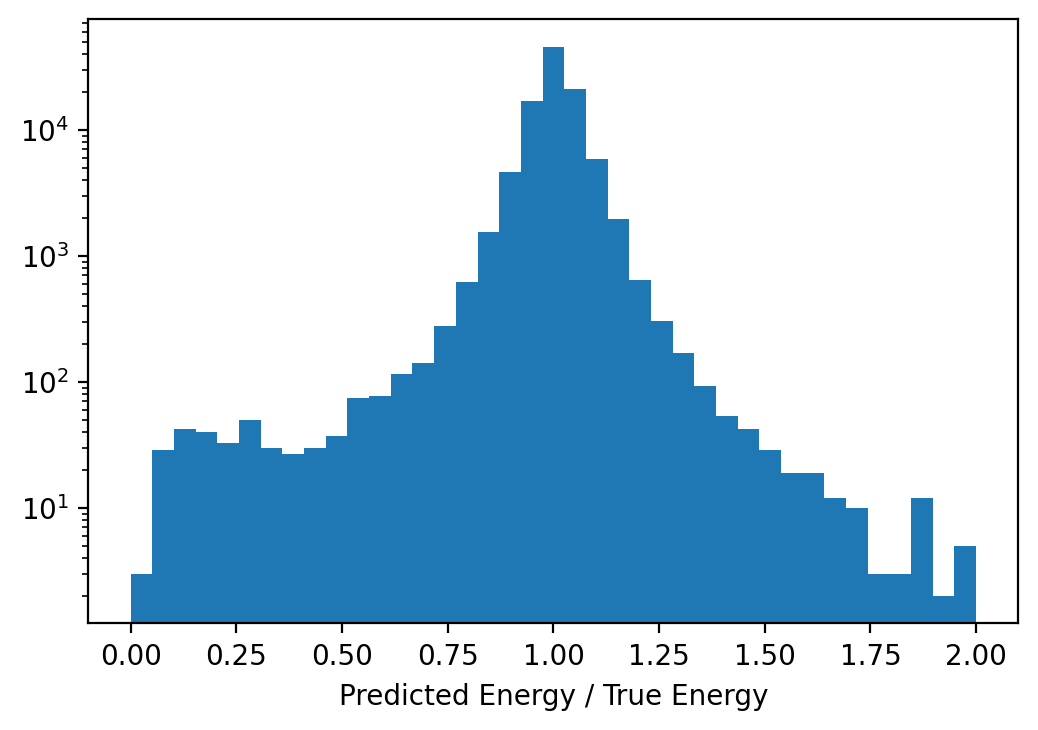

In [230]:
### Evaluate performance on test set 
plt.figure(dpi=200)
df_test['nn_output'] = model.predict(test_x)
plt.hist(10**df_test.nn_output/10**df_test.log10_truth_particle_e, bins=np.linspace(0.,2.,40));
plt.yscale('log')
plt.xlabel('Predicted Energy / True Energy')

In [231]:
np.min(10**df_test[df_test.truth_particle_e < 100].nn_output/10**df_test[df_test.truth_particle_e < 100].log10_truth_particle_e)

0.018506587308599238

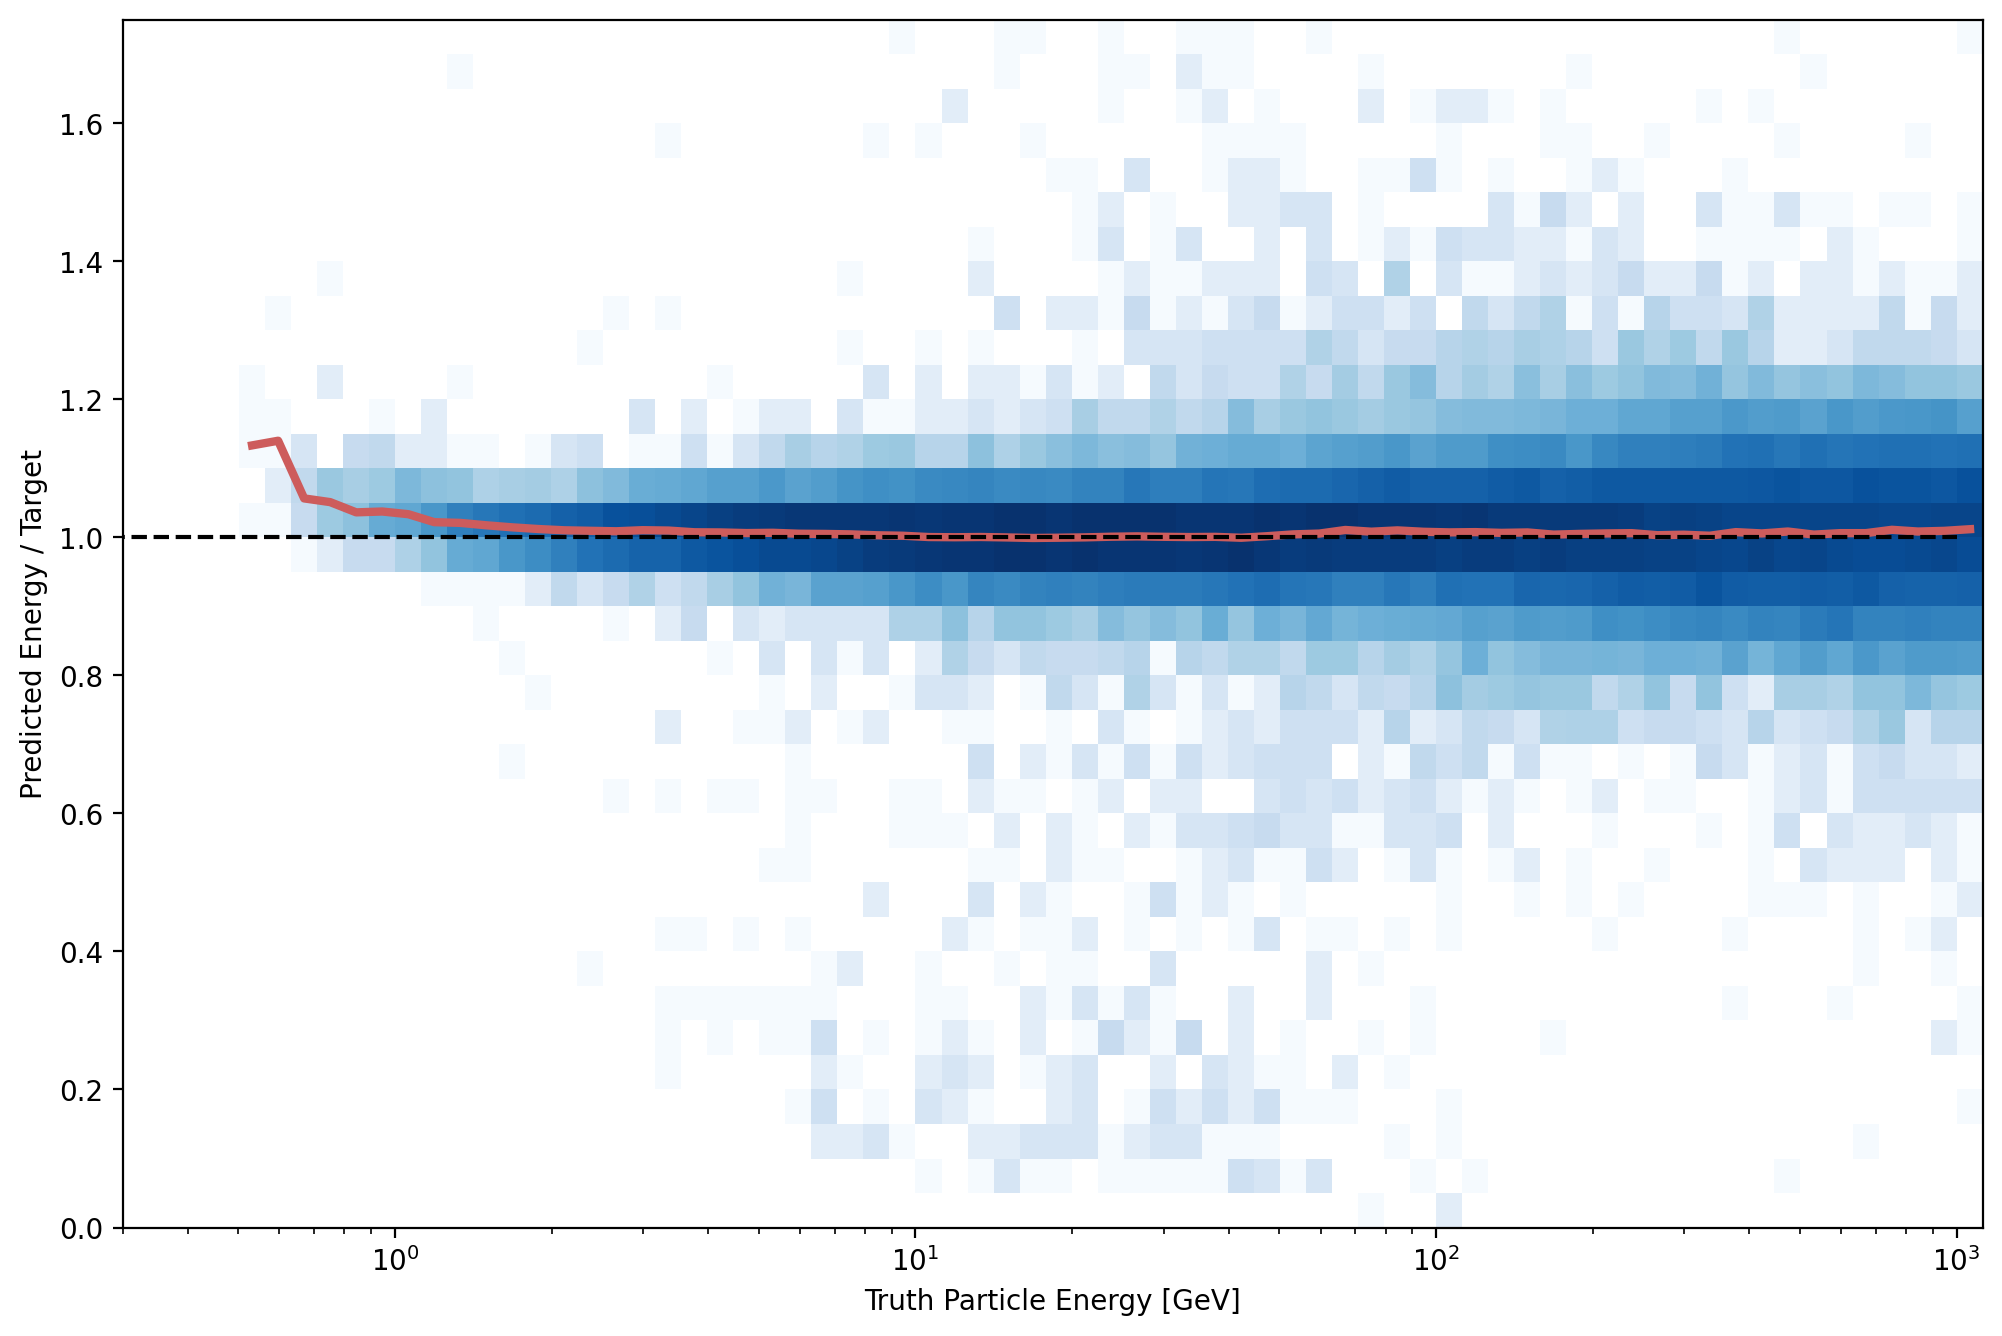

In [232]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = df_test.truth_particle_e
y = (10**df_test.nn_output)/x

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8), dpi=200)
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target');

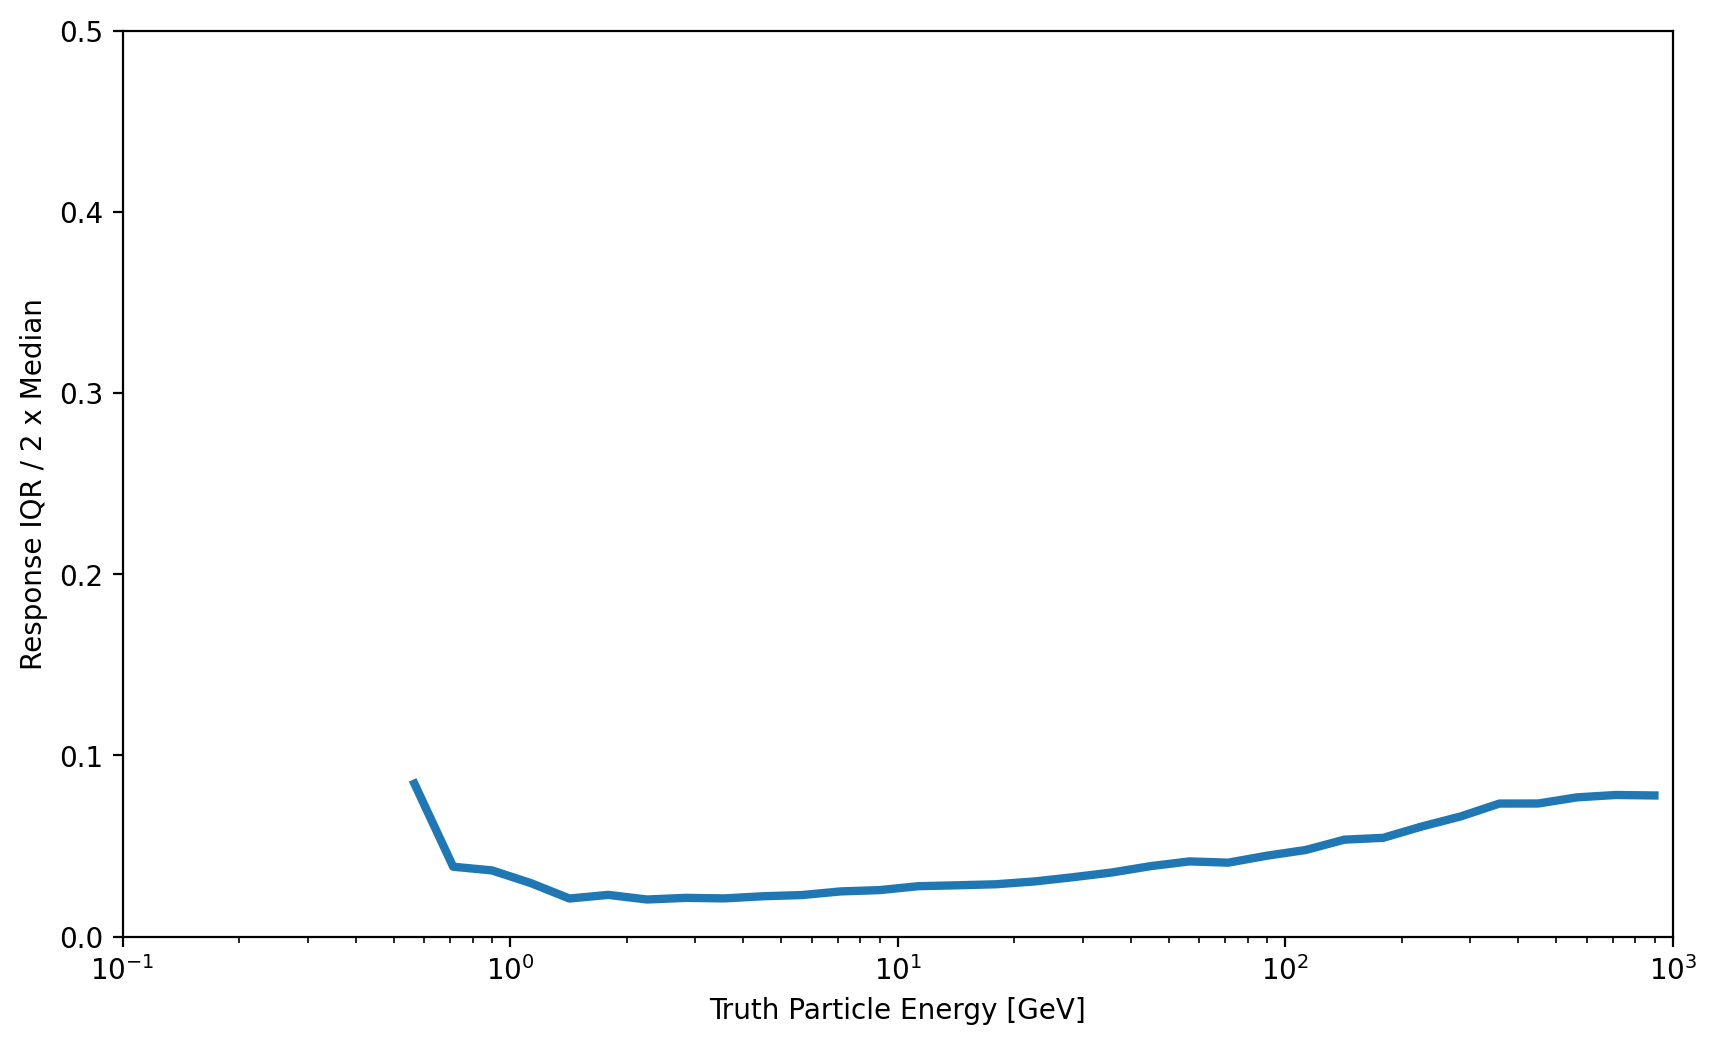

In [233]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

xbin = [10**exp for exp in np.arange(-1., 3.1, 0.1)]
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
resolution = stats.binned_statistic(x, y, bins=xbin, statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6), dpi=200)
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');

Compare with other models...

In [ ]:
pred_file = 'results/onetrack_multicluster/piyush_june22/gnn_allclusters_cells/inference_predictions.npz'
predictions = np.load(pred_file)
targets_regress = predictions['targets']
outputs_regress = predictions['outputs'][:,0]
df = pd.DataFrame(np.vstack([targets_regress, outputs_regress]).T, columns=['targets_regress', 'outputs_regress'])

In [ ]:
plt.figure(dpi=200)
plt.hist(df_transformer.outputs_regress/df_transformer.targets_regress, 
        bins=np.linspace(0.5,1.5,100),
         label="Transformer",
        );
plt.legend()
plt.xlabel("Predicted Energy / Target Energy");
plt.ylabel("Events");

In [ ]:
plt.figure(dpi=200)
plt.hist(df_test.truth_particle_e, label="DNN", histtype="step", alpha=1., density=True, linewidth=2);
plt.hist(df.targets_regress, label="GNN", histtype="step", alpha=1., density=True, linewidth=2);
plt.hist(df_transformer.targets_regress, label="Transformer", histtype="step", alpha=1., density=True, linewidth=2);
plt.legend();
plt.xlabel("Target Energy [GeV]");

# Misc

In [ ]:
train = pd.read_hdf("train_dnn.h5")
val = pd.read_hdf("val_dnn.h5")
test = pd.read_hdf("test_dnn.h5")

In [ ]:
import uproot
from glob import glob
import json 
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

variables = ["nTrack", "truthPartE"]

df_all = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df_all["truthPartE"] = df_all.truthPartE.astype('float')
df_all.reset_index(inplace=True)

In [ ]:
pi0_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pion_dir = '/clusterfs/ml4hep/mpettee/ml4pions/data/root_files/user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/'
pi0_files = sorted(glob(pi0_dir+"*.root"))
pion_files = sorted(glob(pion_dir+"*.root"))

variables = ["nTrack", "truthPartE", "cluster_E"]

df = pd.concat([pd.DataFrame(uproot.open(file)["EventTree"].arrays(variables, library = "np")) 
                for file in tqdm(pion_files)])
df["truthPartE"] = df.truthPartE.astype('float')
df.reset_index(inplace=True)

print(df[(df.truthPartE < 0.201)].nTrack.value_counts())
print("Minimum truthPartE with nTrack == 1 is {:.5f}.".format(df[df.nTrack == 1].truthPartE.min()))


In [ ]:
cluster_e = []
for i in tqdm(range(len(df))): 
    event_pass = True
    for cluster in range(len(df.cluster_E.iloc[i])):
        if np.array(df.cluster_E.iloc[i][cluster]) > 0.5: 
            event_pass = False
            continue
    cluster_e.append(event_pass)